In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.utils import multi_runs
from bokeh.io import output_notebook, show
# from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison
import pysindy as ps
import glob
import pandas as pd


from os.path import basename
import os
import sys


cwd = os.path.dirname(os.path.abspath(''))
print(cwd)
sys.path.append(cwd + '/Cpp/build/Binders/')
import pyFROLS as pf

DATA_DIR = cwd + '/Cpp/data/'
FIGURE_DIR = cwd + '/../../figures/'

/home/man/Documents/Bernoulli_MC


In [2]:
N_pop = 100
p_ER = 1
d_max = 1
N_output_max = 80
Nx = 3
Nu = 1
Nt = 50
er_model = pf.Polynomial_Model(Nx,Nu,N_output_max,d_max)
er_model.read_csv(DATA_DIR + 'ERR_Simulation_SIR_' + str(N_pop) + '_' + str(p_ER) + '/param.csv')
er_model.feature_summary()


       y           Feature           g            Theta          f_ERR           Tag      
       0             x0            0.986          0.998          0.999       PRESELECTED         4       
       0           x0x1u0         -0.205         -0.205          0.000       PRESELECTED        13       
       1             x1            0.987          0.862          0.985       PRESELECTED         3       
       1           x0x1u0          0.259          0.259          0.004       PRESELECTED        13       
       2             x2            1.017          0.999          0.999       PRESELECTED         2       
       2             x1            0.107          0.107          0.001       PRESELECTED         3       


In [3]:
qr_model = pf.Polynomial_Model(Nx,Nu,N_output_max,d_max)
qr_model.read_csv(DATA_DIR + 'Quantile_Simulation_SIR_' + str(N_pop) + '_' + str(p_ER) + '/param.csv')
qr_model.feature_summary()

       y           Feature           g            Theta          f_ERR           Tag      
       0             x0            0.958          0.966         153.267      PRESELECTED         4       
       0           x0x1u0         -0.123         -0.123         84.117       PRESELECTED        13       
       1             x1            1.043          0.831         871.435      PRESELECTED         3       
       1           x0x1u0          0.442          0.442         433.828      PRESELECTED        13       
       2             x2            1.000          0.982         570.950      PRESELECTED         2       
       2             x1            0.104          0.104         124.508      PRESELECTED         3       


In [4]:
print(er_model.equations())


['0.998316 x0  + -0.204587 x0 x1 u0 ', '0.862451 x1  + 0.258920 x0 x1 u0 ', '0.998890 x2  + 0.106600 x1 ']


In [5]:
from pysindy_casadi_converter import construct_mx_equations
import casadi as cs


In [6]:
# def RK4(f, x0, u, h):
#     k1 = h/4*f(x0, u)
#     k2 = h/4*f(x0 + k1/2, u)
#     k3 = h/4*f(x0 + k2/2, u)
#     k4 = h/4*f(x0 + k3, u)
#     return x0 + (k1 + 2*k2 + 2*k3 + k4)/6

# def N_RK4(f, x0, u, h, N):
#     xk = x0
#     for i in range(N):
#         xk = RK4(f, xk, u, h/N)
#     return xk

In [7]:
def load_SIR_trajectories():
    trajs = glob.glob(DATA_DIR + 'ERR_Simulation_SIR_' + str(N_pop) + '_' + str(p_ER) + '/trajectory*.csv')
    dfs = [pd.read_csv(traj) for traj in trajs[:100] if "Quantile" not in traj]
    
    print(dfs[0].columns)
    N_traj = len(dfs)
    X = [df[['S', 'I', 'R']].to_numpy() for df in dfs]
    U = [df['p_I'].to_numpy() for df in dfs]

    return X, U

X_sim, U_sim = load_SIR_trajectories()
#get mean of all X_sim
X_mean = np.mean(np.array(X_sim), axis=0)
U_mean = np.mean(np.array(U_sim), axis=0)

Index(['I', 'R', 'S', 'p_I', 't'], dtype='object')


In [8]:
def quadratic_objective_solve(X_mean, U_mean, Wu, regression_model):
    xk = cs.MX.sym('X', Nx)
    uk = cs.MX.sym('U', Nu)
    eqs = cs.vertcat(*construct_mx_equations(xk, uk, regression_model))
    F_ODE = cs.Function('F', [xk, uk], [eqs])
    X = cs.MX.sym('X', Nx, Nt)
    U = cs.MX.sym('U', Nu, Nt)

    g = []
    u_max = 0.1
    u_min = 0.000001
    obj = 0

    gx = []
    Wu = 100000
    obj = 0
    X_traj = [X_mean[0,:]]
    Xs = cs.MX.sym('Xs', Nx)
    obj = 0
    for i in range(Nt):
        if (i == 0):
            Xk = F_ODE(X_mean[0,:], U[i])
        else:
            Xk = F_ODE(Xk, U[i])
        X_traj.append(Xk)
        obj += Wu*(u_max - U[i])**2 + (Xk[1])**2
    get_X = cs.Function('get_X', [U], [cs.horzcat(*X_traj)])

    X0 = X_mean
    U0 = U_mean
    # prob = {'f': obj, 'x': W, 'g': g}
    # solver = cs.nlpsol('solver', 'ipopt', prob)
    lbx = [u_min]*Nt
    ubx = [u_max]*Nt
    # for i in range(Nt):
    #     ubx[1+3*i] = I_max
    # sol = solver(x0=cs.vertcat(X0[:], U_mean), lbx = lbw, ubx = ubw, lbg = lbg, ubg=ubg)
    prob = {'f': obj, 'x': U, 'g': []}
    solver = cs.nlpsol('solver', 'ipopt', prob)
    sol = solver(x0=U0, lbx = cs.vertcat(*lbx), ubx = cs.vertcat(*ubx))

    return (sol, get_X(sol['x'].full()), sol['x'].full())

In [9]:
Wu = 10000
(qr_sol, qr_X, qr_U) = quadratic_objective_solve(X_mean, U_mean, Wu, qr_model)
(er_sol, er_X, er_U) = quadratic_objective_solve(X_mean, U_mean, Wu, er_model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1275

Total number of variables............................:       50
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       50
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality co

(1, 50)


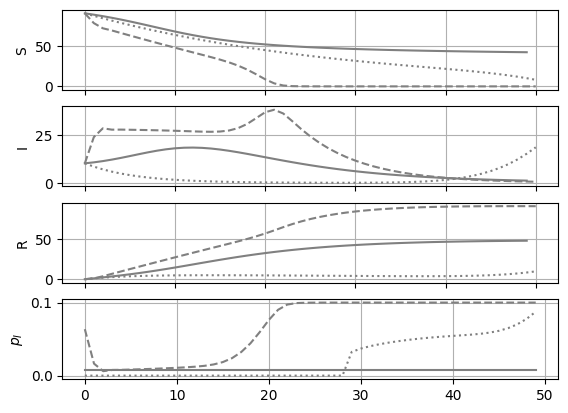

In [10]:

print(er_U.shape)
fig, ax = plt.subplots(4)
for i in range(Nx):
    ax[i].plot(X_mean[:,i], color='gray', label='Mean')
    ax[i].plot(er_X[i, :].T, color='gray', linestyle='dashed')
    ax[i].plot(qr_X[i, :].T, color='gray', linestyle='dotted')
ax[-1].plot(U_mean,  color='gray', label='Mean')
ax[-1].plot(er_U.T,  color='gray', linestyle='dashed', label='ERR-Model')
ax[-1].plot(qr_U.T,  color='gray', linestyle='dotted', label='Quantile-Model')
_ = [x.set_ylabel(s) for x, s in zip(ax, ['S', 'I', 'R', r'$p_I$'])]
#remove x tick labels from upper plots
_ = [x.set_xticklabels([]) for x in ax[:-1]]
fig.subplots_adjust(hspace=0.2)
_ = [x.grid() for x in ax]
# ax[-1].legend()

In [ ]:

er_sims = pf.Bernoulli_SIR_MC_Simulations(N_pop, p_ER, 100, list(er_U[0]))
qr_sims = pf.Bernoulli_SIR_MC_Simulations(N_pop, p_ER, 100, list(qr_U[0]))
er_X_list = [np.array([x[0], x[1], x[2]]) for x in er_sims]
qr_X_list = [np.array([x[0], x[1], x[2]]) for x in qr_sims]

In [ ]:
fig, ax = plt.subplots(4)
for i in range(Nx):
    ax[i].plot(er_X[i, :].T, color='gray', linestyle='dashed')
    ax[i].plot(qr_X[i, :].T, color='gray', linestyle='dotted')
    #plot er_X_list and qr_X_list
    for j in range(len(er_X_list)):
        ax[i].plot(er_X_list[j][i, :].T, color='gray', linestyle='dashed', alpha=0.1)
        ax[i].plot(qr_X_list[j][i, :].T, color='gray', linestyle='dotted', alpha=0.1)
ax[-1].plot(U_mean,  color='gray', label='Mean')
ax[-1].plot(er_U.T,  color='gray', linestyle='dashed', label='ERR-Model')
ax[-1].plot(qr_U.T,  color='gray', linestyle='dotted', label='Quantile-Model')
_ = [x.set_ylabel(s) for x, s in zip(ax, ['S', 'I', 'R', r'$p_I$'])]
#remove x tick labels from upper plots
_ = [x.set_xticklabels([]) for x in ax[:-1]]
fig.subplots_adjust(hspace=0.2)
_ = [x.grid() for x in ax]
# ax[-1].legend()

In [11]:
def hospital_capacity_objective_solve(X_mean, U_mean, Wu, I_max, regression_model):
    xk = cs.MX.sym('X', Nx)
    uk = cs.MX.sym('U', Nu)
    eqs = cs.vertcat(*construct_mx_equations(xk, uk, regression_model))
    F_ODE = cs.Function('F', [xk, uk], [eqs])
    X = cs.MX.sym('X', Nx, Nt)
    U = cs.MX.sym('U', Nu, Nt)

    g = []
    u_max = 0.1
    u_min = 0.000001
    obj = 0

    gx = []
    obj = 0
    X_traj = [X_mean[0,:]]
    Xs = cs.MX.sym('Xs', Nx)
    obj = 0
    for i in range(Nt):
        if (i == 0):
            Xk = F_ODE(X_mean[0,:], U[i])
        else:
            Xk = F_ODE(Xk, U[i])
        X_traj.append(Xk)
        obj += Wu*(u_max - U[i])**2 + (Xk[1])**2
        gx.append(Xk[1] - I_max)
    get_X = cs.Function('get_X', [U], [cs.horzcat(*X_traj)])

    X0 = X_mean
    U0 = U_mean
    # prob = {'f': obj, 'x': W, 'g': g}
    # solver = cs.nlpsol('solver', 'ipopt', prob)
    lbx = [u_min]*Nt
    ubx = [u_max]*Nt
    ubg = [0]*Nt
    lbg = [0]*Nt
    # for i in range(Nt):
    #     ubx[1+3*i] = I_max
    # sol = solver(x0=cs.vertcat(X0[:], U_mean), lbx = lbw, ubx = ubw, lbg = lbg, ubg=ubg)
    prob = {'f': obj, 'x': U, 'g': cs.vertcat(*gx)}
    # prob = {'f': obj, 'x': U, 'g': g}
    Ng = len(gx)
    lbg = cs.DM.zeros(Ng)
    ubg = cs.DM.zeros(Ng)
    solver = cs.nlpsol('solver', 'ipopt', prob)
    sol = solver(x0=U0, lbx = cs.vertcat(*lbx), ubx = cs.vertcat(*ubx), ubg = ubg, lbg = lbg)

    return (sol, get_X(sol['x'].full()), sol['x'].full())

In [12]:
Wu = 10000
I_max = 25
(qr_sol, qr_X, qr_U) = hospital_capacity_objective_solve(X_mean, U_mean, Wu, I_max, qr_model)
(er_sol, er_X, er_U) = hospital_capacity_objective_solve(X_mean, U_mean, Wu, I_max, er_model)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1275
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1275

Total number of variables............................:       50
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       50
                     variables with only upper bounds:        0
Total number of equality constraints.................:       50
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5512694e+04 2.44e+01 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

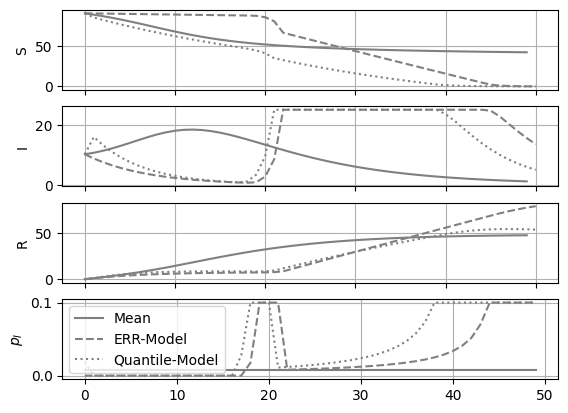

In [22]:
fig, ax = plt.subplots(4)
for i in range(Nx):
    ax[i].plot(X_mean[:,i], color='gray', label='Mean')
    ax[i].plot(er_X[i, :].T, color='gray', linestyle='dashed')
    ax[i].plot(qr_X[i, :].T, color='gray', linestyle='dotted')
ax[-1].plot(U_mean,  color='gray', label='Mean')
ax[-1].plot(er_U.T,  color='gray', linestyle='dashed', label='ERR-Model')
ax[-1].plot(qr_U.T,  color='gray', linestyle='dotted', label='Quantile-Model')
_ = [x.set_ylabel(s) for x, s in zip(ax, ['S', 'I', 'R', r'$p_I$'])]
#remove x tick labels from upper plots
_ = [x.set_xticklabels([]) for x in ax[:-1]]
fig.subplots_adjust(hspace=0.2)
_ = [x.grid() for x in ax]
ax[-1].legend()

In [14]:
er_sims = pf.Bernoulli_SIR_MC_Simulations(N_pop, p_ER, 100, list(er_U[0]))
qr_sims = pf.Bernoulli_SIR_MC_Simulations(N_pop, p_ER, 100, list(qr_U[0]))


size: 32
Simulation 0 of 100
Simulation 10 of 100
Simulation 20 of 100
Simulation 30 of 100
Simulation 40 of 100
Simulation 50 of 100
Simulation 60 of 100
Simulation 70 of 100
Simulation 80 of 100
Simulation 90 of 100
size: 32
Simulation 0 of 100
Simulation 10 of 100
Simulation 20 of 100
Simulation 30 of 100
Simulation 40 of 100
Simulation 50 of 100
Simulation 60 of 100
Simulation 70 of 100
Simulation 80 of 100
Simulation 90 of 100


In [20]:
er_X_list = [np.array([x[0], x[1], x[2]]) for x in er_sims]
qr_X_list = [np.array([x[0], x[1], x[2]]) for x in qr_sims]



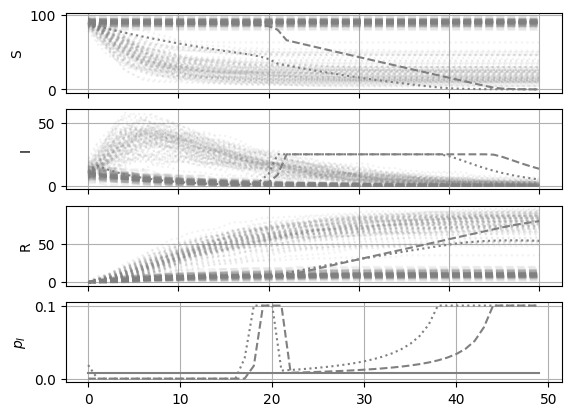

In [21]:
fig, ax = plt.subplots(4)
for i in range(Nx):
    ax[i].plot(er_X[i, :].T, color='gray', linestyle='dashed')
    ax[i].plot(qr_X[i, :].T, color='gray', linestyle='dotted')
    #plot er_X_list and qr_X_list
    for j in range(len(er_X_list)):
        ax[i].plot(er_X_list[j][i, :].T, color='gray', linestyle='dashed', alpha=0.1)
        ax[i].plot(qr_X_list[j][i, :].T, color='gray', linestyle='dotted', alpha=0.1)
ax[-1].plot(U_mean,  color='gray', label='Mean')
ax[-1].plot(er_U.T,  color='gray', linestyle='dashed', label='ERR-Model')
ax[-1].plot(qr_U.T,  color='gray', linestyle='dotted', label='Quantile-Model')
_ = [x.set_ylabel(s) for x, s in zip(ax, ['S', 'I', 'R', r'$p_I$'])]
#remove x tick labels from upper plots
_ = [x.set_xticklabels([]) for x in ax[:-1]]
fig.subplots_adjust(hspace=0.2)
_ = [x.grid() for x in ax]
# ax[-1].legend()